In [55]:
import sys
sys.path.append('..')
from src.kitti import *
import numpy as np
import cv2
import json
import glob
from src.boundingbox import format_yolo_output
from src.trajectory import Trajectory

%matplotlib inline

### Analyzing KITTI sequence 00 image_2

In [57]:
LEFTDIR = '/data/urbinn/datasets/kitti/sequences/00/image_2'
RIGHTDIR = '/data/urbinn/datasets/kitti/sequences/00/image_3'

yolo_data = format_yolo_output("/data/urbinn/darknet/output/seq00_image02/objects.json")
                
frames = []
for filename in sorted(glob.glob(LEFTDIR + '/*')): 
    image_name = filename.split('/')[-1]
    frame = None
    
    if not image_name in yolo_data:
        print("frame {} has no yolo data available".format(image_name))
        frame = Frame(filename, RIGHTDIR)
    else:
        frame = Frame(filename, RIGHTDIR, yolo_data[image_name])
        
    frames.append(frame)

frame 004540.png has no yolo data available


Note: For some reason frame 004540 has no objects detected. This might be possible but requires further investigation.

#### Setting up a sequence

In [ ]:
seq = Sequence()
for f in ProgressBar()(frames[:100]):
    seq.add_keyframe(f)

 87% (87 of 100) |####################    | Elapsed Time: 0:01:35 ETA:  0:00:14

In [ ]:
DIMENSION = 400

poses = [kf.get_pose() for kf in seq.keyframes]

In order to plot the observations it is necessary to convert them to real world coordinates.

In [ ]:
points_per_frame = []
for kf in seq.keyframes:
    kf.update_observations_per_classification()
    kf.filter_no_classification()
    obs = kf.get_observations()
    
    points_per_frame.append(obs)

#print(seq.keyframes[1].frameid, len(seq.keyframes[1].frames))
#print(points_per_frame)
show(draw_observations_depth(points_per_frame[1]))

['car']
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]
 [ -5.61409296e-02  -2.07032530e-02   1.32439907e+00   1.00000000e+00]
 [ -8.39832158e-02  -2.07412595e-02   2.72701188e+00   1.00000000e+00]
 [ -7.99715951e-02  -4.91956251e-02   4.13386573e+00   1.00000000e+00]
 [ -1.26879877e-01  -6.55690192e-02   5.46806889e+00   1.00000000e+00]
 [ -1.81188769e-01  -7.84726785e-02   6.78823284e+00   1.00000000e+00]
 [ -2.01003734e-01  -7.47853092e-02   8.18007166e+00   1.00000000e+00]
 [ -2.70243001e-01  -8.44131099e-02   9.45939464e+00   1.00000000e+00]
 [ -3.09432060e-01  -1.09776416e-01   1.08647269e+01   1.00000000e+00]
 [ -3.32120932e-01  -1.59012028e-01   1.22392694e+01   1.00000000e+00]
 [ -3.56301481e-01  -1.89666626e-01   1.35868393e+01   1.00000000e+00]
 [  3.50720703e-02  -2.90343588e-01   1.42310360e+01   1.00000000e+00]
 [ -3.44855290e-03  -2.82931618e-01   1.56128455e+01   1.00000000e+00]
 [ -1.70386587e-02  -2.56485619e-01   1.70360006e+01   1.00000000e+00

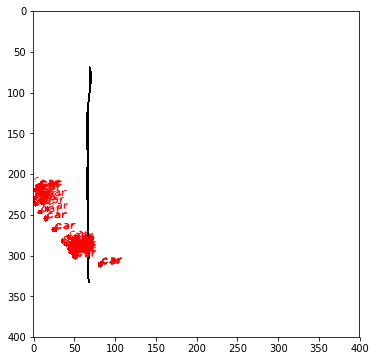

In [54]:
classifications = []
for obs in flatten(points_per_frame):
    if obs.classification not in classifications:
        classifications.append(obs.classification)
        
#print([obs.classification for obs in points_per_frame[9]])
print(classifications)
flatten = lambda l: [item for sublist in l for item in sublist]
flattened = flatten(points_per_frame)
#print(len(flattened))
trajectory = Trajectory(poses, (DIMENSION, DIMENSION), flattened)
show(trajectory.draw(True, True))
#trajectory._observations_rwc